# 1. Configuración del Entorno

Al igual que en la validación, importamos las librerías estándar y configuramos el acceso a nuestra carpeta `src/`. También definimos una función auxiliar `mostrar_imagen` para facilitar la visualización de los resultados intermedios sin repetir código.

In [1]:
# Importamos librerias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
# --- Configurar rutas ---
# Agregamos el directorio raíz para importar los módulos de 'src'
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Importar nuestros módulos de visión
from src import feature_detection, matching, registration

# Configuración de gráficas
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

# Función auxiliar para visualizar imágenes
def mostrar_imagen(img, titulo="Imagen"):
    if img is None: return
    # OpenCV usa BGR, Matplotlib usa RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

print("✅ Entorno listo para el registro de imágenes.")

✅ Entorno listo para el registro de imágenes.


# 2. Carga y Organización de las Imágenes

Cargamos las tres fotografías del comedor desde la carpeta `data/original`.
**Importante:** El orden es crucial para la fusión:
1.  **Izquierda** (`IMG01.jpg`)
2.  **Centro** (`IMG02.jpg`) - Esta será nuestra ancla inicial.
3.  **Derecha** (`IMG03.jpg`)

Visualizamos las imágenes cargadas para confirmar que están en el orden visual correcto (de izquierda a derecha).

📂 Cargando imágenes del comedor...
  - Cargada: IMG01.jpg | Resolución: (912, 684, 3)
  - Cargada: IMG02.jpg | Resolución: (912, 684, 3)
  - Cargada: IMG03.jpg | Resolución: (912, 1216, 3)


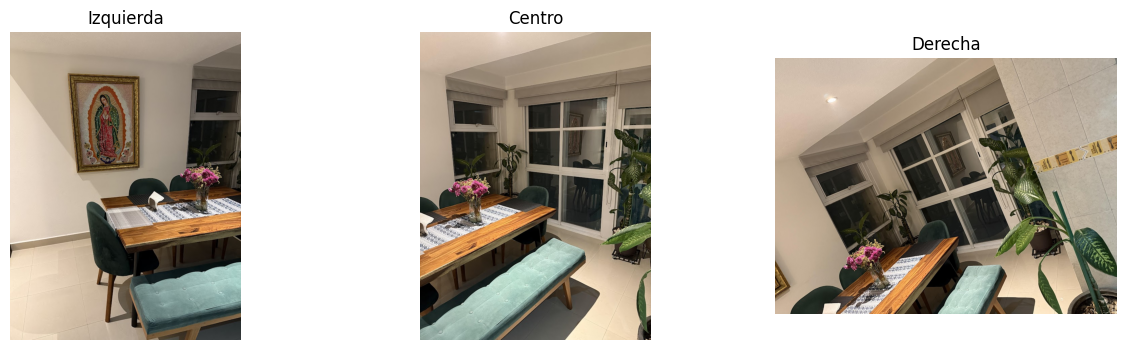

In [4]:
data_dir = os.path.join(project_root, 'data', 'original')

# Ajusta estos nombres si tus archivos se llaman diferente
nombres_archivos = ['IMG01.jpg', 'IMG02.jpg', 'IMG03.jpg'] 
imagenes = []

print("📂 Cargando imágenes del comedor...")

for n in nombres_archivos:
    path = os.path.join(data_dir, n)
    img = cv2.imread(path)
    if img is not None:
        imagenes.append(img)
        print(f"  - Cargada: {n} | Resolución: {img.shape}")
    else:
        print(f"  ❌ Error fatal: No se pudo cargar {n}")

# Visualización previa
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titulos = ["Izquierda", "Centro", "Derecha"]

if len(imagenes) == 3:
    for ax, img, t in zip(axes, imagenes, titulos):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(t)
        ax.axis('off')
    plt.show()
else:
    print("⚠️ Advertencia: No se cargaron las 3 imágenes necesarias.")

# 3. Función de Fusión y Expansión del Lienzo (Canvas)

Esta es la función más compleja y vital del proyecto. [cite_start]Realiza los siguientes pasos [cite: 28-31]:

1.  **Detección:** Extrae puntos SIFT de ambas imágenes.
2.  **Matching:** Encuentra correspondencias y filtra las malas usando el *Ratio Test*.
3.  **Homografía:** Calcula la transformación geométrica usando RANSAC para ignorar outliers.
4.  **Cálculo del Lienzo (Canvas):**
    * Al deformar una imagen, esta puede moverse a coordenadas negativas o salirse del tamaño original.
    * Calculamos dónde caerán las 4 esquinas de la nueva imagen transformada.
    * Creamos una **matriz de traslación** para mover todo al cuadrante positivo y expandimos el tamaño de la imagen final.
5.  **Blending:** Superpone las imágenes en el nuevo lienzo expandido.

In [7]:
def unir_imagenes(img_base, img_nueva):
    """
    Registra 'img_nueva' sobre el sistema de coordenadas de 'img_base'.
    Maneja automáticamente la expansión del tamaño de la imagen.
    """
    print(f"🔄 Iniciando fusión de imágenes ({img_nueva.shape} -> {img_base.shape})...")
    
    # 1. Detectar Características (SIFT)
    kp_base, desc_base = feature_detection.detect_features(img_base, 'SIFT')
    kp_new, desc_new = feature_detection.detect_features(img_nueva, 'SIFT')
    
    # 2. Matching Robusto
    matches = matching.match_features(desc_new, desc_base, 'SIFT', ratio_thresh=0.75)
    print(f"   Matches encontrados (filtrados): {len(matches)}")
    
    if len(matches) < 4:
        print("   ⚠️ Error: No hay suficientes matches para calcular la homografía.")
        return None

    # 3. Estimación de Homografía (RANSAC)
    H, mask = registration.estimate_homography(kp_new, kp_base, matches)
    if H is None: return None

    # --- 4. CÁLCULO DEL TAMAÑO DEL NUEVO PANORAMA ---
    h1, w1 = img_nueva.shape[:2]
    h2, w2 = img_base.shape[:2]

    # Obtenemos las coordenadas de las esquinas de la imagen nueva
    pts_esquinas_nueva = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    
    # Proyectamos esas esquinas usando la Homografía
    pts_transformados = cv2.perspectiveTransform(pts_esquinas_nueva, H)
    
    # Obtenemos las esquinas de la imagen base (inicia en 0,0)
    pts_esquinas_base = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    
    # Juntamos todos los puntos para ver los límites extremos
    todos_puntos = np.concatenate((pts_esquinas_base, pts_transformados), axis=0)
    
    # Buscamos los valores extremos
    [x_min, y_min] = np.int32(todos_puntos.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(todos_puntos.max(axis=0).ravel() + 0.5)
    
    # Calculamos la traslación necesaria
    traslacion_x = -x_min if x_min < 0 else 0
    traslacion_y = -y_min if y_min < 0 else 0
    
    # --- CORRECCIÓN AQUÍ: dtype=np.float32 ---
    # Crear matriz de traslación forzando tipo flotante
    H_traslacion = np.array([[1, 0, traslacion_x], 
                             [0, 1, traslacion_y], 
                             [0, 0, 1]], dtype=np.float32)

    # La transformación final es: Primero Homografía, luego Traslación
    H_final = H_traslacion.dot(H)
    
    # Dimensiones finales del lienzo
    ancho_final = x_max - x_min
    alto_final = y_max - y_min
    
    # --- 5. WARPING Y MEZCLA ---
    
    # Deformar la imagen nueva hacia el lienzo final
    img_nueva_warped = cv2.warpPerspective(img_nueva, H_final, (ancho_final, alto_final))
    
    # Mover la imagen base al lienzo final (solo traslación)
    img_base_warped = cv2.warpPerspective(img_base, H_traslacion, (ancho_final, alto_final))
    
    # Mezcla simple (Overlay):
    gray_new = cv2.cvtColor(img_nueva_warped, cv2.COLOR_BGR2GRAY)
    _, mask_pixels = cv2.threshold(gray_new, 1, 255, cv2.THRESH_BINARY)
    
    panorama = img_base_warped.copy()
    panorama[mask_pixels > 0] = img_nueva_warped[mask_pixels > 0]
    
    return panorama

# 4. Ejecución de la Fusión en Cadena

Aplicamos una estrategia secuencial para minimizar la distorsión acumulada:
1.  **Paso A:** Usamos la imagen del **Centro** como base y le fusionamos la imagen de la **Izquierda**.
2.  **Paso B:** Al resultado parcial le fusionamos la imagen de la **Derecha**.

El resultado final se guarda en la carpeta `results/`.


--- 1️⃣ Fusionando Centro con Izquierda ---
🔄 Iniciando fusión de imágenes ((912, 684, 3) -> (912, 684, 3))...
   Matches encontrados (filtrados): 217


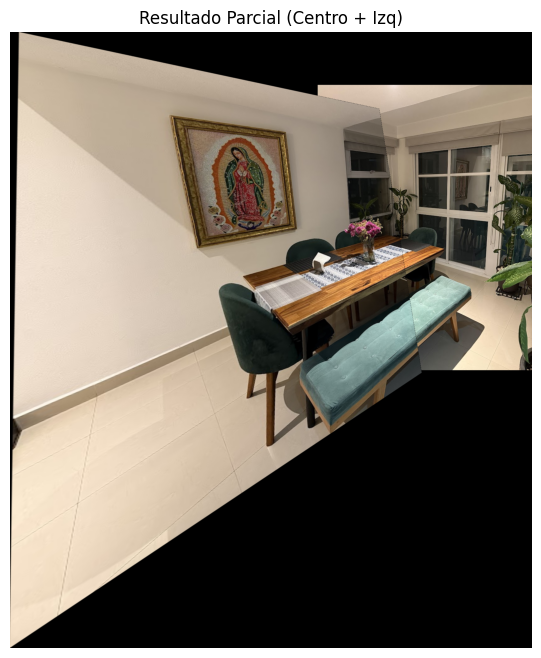


--- 2️⃣ Fusionando Resultado con Derecha ---
🔄 Iniciando fusión de imágenes ((912, 1216, 3) -> (1969, 1666, 3))...
   Matches encontrados (filtrados): 391

✅ ¡Fusión Completa Exitosa!


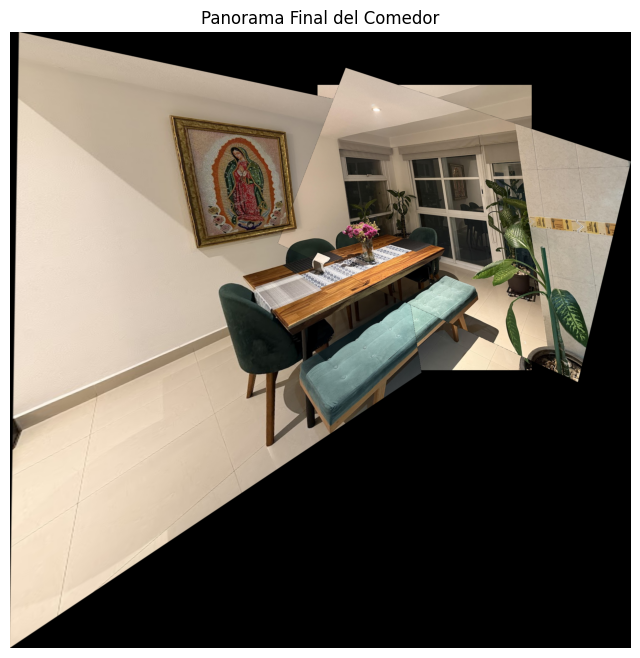

💾 Panorama guardado en: d:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_2\proyecto_registro_imagenes\results\panorama_comedor.jpg


In [8]:
if len(imagenes) == 3:
    # Definimos roles
    img_izquierda = imagenes[0]
    img_centro    = imagenes[1]
    img_derecha   = imagenes[2]

    # --- PASO 1: Centro + Izquierda ---
    print("\n--- 1️⃣ Fusionando Centro con Izquierda ---")
    panorama_parcial = unir_imagenes(img_base=img_centro, img_nueva=img_izquierda)

    if panorama_parcial is not None:
        mostrar_imagen(panorama_parcial, "Resultado Parcial (Centro + Izq)")
        
        # --- PASO 2: Resultado + Derecha ---
        print("\n--- 2️⃣ Fusionando Resultado con Derecha ---")
        # Ahora el panorama parcial es nuestra nueva "base"
        panorama_final = unir_imagenes(img_base=panorama_parcial, img_nueva=img_derecha)
        
        if panorama_final is not None:
            print("\n✅ ¡Fusión Completa Exitosa!")
            mostrar_imagen(panorama_final, "Panorama Final del Comedor")
            
            # Guardar en disco
            output_dir = os.path.join(project_root, 'results')
            if not os.path.exists(output_dir): os.makedirs(output_dir)
            
            output_path = os.path.join(output_dir, 'panorama_comedor.jpg')
            cv2.imwrite(output_path, panorama_final)
            print(f"💾 Panorama guardado en: {output_path}")
        else:
            print("❌ Falló la fusión de la parte derecha.")
    else:
        print("❌ Falló la primera fusión.")
else:
    print("No se puede ejecutar el pipeline sin las 3 imágenes cargadas.")

# 5. Calibración y Medición del Mundo Real (Parte 3)

Una vez obtenido el panorama unificado, procedemos a la última fase: **extraer medidas métricas reales**.

Para esto, utilizaremos la clase `Calibrator` (definida en `src/measurement.py`), la cual nos permitirá:
1.  **Calibrar:** Establecer una relación `píxeles -> centímetros` usando un objeto de dimensiones conocidas.
2.  **Validar:** Medir un segundo objeto conocido para calcular el error del sistema.
3.  **Medir:** Estimar las dimensiones de objetos nuevos en la escena.

In [10]:
from src.measurement import Calibrator
import pandas as pd

# Instanciar la herramienta de calibración
herramienta = Calibrator()

# Cargar el panorama generado en la sección anterior
if 'panorama_final' in locals() and panorama_final is not None:
    herramienta.set_image(panorama_final)
    print("✅ Herramienta de medición inicializada con el panorama generado.")
else:
    print("❌ Error: No se encontró la variable 'panorama_final'. Ejecuta la fusión primero.")

✅ Herramienta de medición inicializada con el panorama generado.


## 5.1. Calibración del Sistema

[cite_start]Según la documentación del taller[cite: 14], el **cuadro de la Virgen de Guadalupe** tiene una altura conocida de **117 cm**. Usaremos este objeto como referencia para calcular nuestro factor de escala.

**Instrucciones:**
1.  Se abrirá una ventana emergente mostrando el panorama.
2.  Haga clic en la parte **superior** del cuadro de la virgen.
3.  Haga clic en la parte **inferior** del cuadro de la virgen.
4.  Presione cualquier tecla para cerrar la ventana y confirmar.

In [23]:
print("--- PASO 1: CALIBRACIÓN (Referencia: Cuadro de la Virgen) ---")
print("👉 Tarea: Haz clic en el borde superior del cuadro de la virgen y luego en el borde inferior.")

# Dato proporcionado en el PDF
ALTURA_REAL_CUADRO = 117.0 # cm

# Abrir interfaz interactiva
puntos_ref = herramienta.seleccionar_puntos_interactivo("Calibracion: Cuadro Virgen")

if len(puntos_ref) == 2:
    # Calcular factor de escala (cm por píxel)
    factor_escala = herramienta.calibrate(puntos_ref[0], puntos_ref[1], ALTURA_REAL_CUADRO)
else:
    print("⚠️ No se seleccionaron los puntos necesarios. Intente nuevamente.")

--- PASO 1: CALIBRACIÓN (Referencia: Cuadro de la Virgen) ---
👉 Tarea: Haz clic en el borde superior del cuadro de la virgen y luego en el borde inferior.
👉 Haz clic en 2 puntos en la ventana 'Calibracion: Cuadro Virgen'.
   (Presiona cualquier tecla para confirmar cuando termines)
✅ Sistema Calibrado: 308.00 px = 117.0 cm
   Factor: 2.6324 px/cm


## 5.2. Validación de la Precisión

[cite_start]Para verificar qué tan confiables son nuestras mediciones, mediremos un segundo objeto con dimensiones conocidas: la **Mesa del Comedor**, cuyo ancho real es **161.1 cm**[cite: 14].

Calcularemos el error absoluto y relativo entre nuestra medición y el valor real (Ground Truth).

In [24]:
print("\n--- PASO 2: VALIDACIÓN (Objeto: Mesa del Comedor) ---")
print("👉 Tarea: Haz clic en el extremo IZQUIERDO y DERECHO de la mesa.")

# Dato proporcionado en el PDF
ANCHO_REAL_MESA = 161.1 # cm

puntos_mesa = herramienta.seleccionar_puntos_interactivo("Validacion: Mesa")

if len(puntos_mesa) == 2:
    # Realizar medición
    medida_calculada = herramienta.measure(puntos_mesa[0], puntos_mesa[1])
    
    # Calcular métricas de error
    error_abs = abs(medida_calculada - ANCHO_REAL_MESA)
    error_rel = (error_abs / ANCHO_REAL_MESA) * 100
    
    print(f"📏 Medida calculada: {medida_calculada:.2f} cm")
    print(f"📝 Medida real (GT): {ANCHO_REAL_MESA:.2f} cm")
    print(f"📉 Error:            {error_abs:.2f} cm ({error_rel:.2f}%)")
    
    if error_rel < 5.0:
        print("✅ ¡Excelente precisión! (< 5% de error)")
    else:
        print("⚠️ Precisión moderada. Revise si los puntos fueron seleccionados correctamente.")
else:
    print("⚠️ Faltan puntos para medir la mesa.")


--- PASO 2: VALIDACIÓN (Objeto: Mesa del Comedor) ---
👉 Tarea: Haz clic en el extremo IZQUIERDO y DERECHO de la mesa.
👉 Haz clic en 2 puntos en la ventana 'Validacion: Mesa'.
   (Presiona cualquier tecla para confirmar cuando termines)
📏 Medida calculada: 78.52 cm
📝 Medida real (GT): 161.10 cm
📉 Error:            82.58 cm (51.26%)
⚠️ Precisión moderada. Revise si los puntos fueron seleccionados correctamente.


## 5.3. Medición de Nuevos Elementos

[cite_start]Finalmente, estimaremos las dimensiones de **al menos 3 elementos adicionales** en la escena[cite: 35].

Los resultados se guardarán en un archivo CSV en la carpeta `results/` para ser incluidos en el reporte final.

In [26]:
print("\n--- PASO 3: MEDICIÓN DE OBJETOS ADICIONALES ---")

# Lista de objetos sugeridos por el taller
objetos_a_medir = [
    "Silla (Altura del Respaldo)", 
    "Ventana (Ancho visible)", 
    "Planta/Maceta (Altura aprox)"
]

resultados_medicion = []

for obj_nombre in objetos_a_medir:
    print(f"\n👉 Midiendo: {obj_nombre}...")
    pts = herramienta.seleccionar_puntos_interactivo(f"Midiendo: {obj_nombre}")
    
    if len(pts) == 2:
        valor = herramienta.measure(pts[0], pts[1])
        resultados_medicion.append({
            "Objeto": obj_nombre,
            "Medida Estimada (cm)": round(valor, 2)
        })
        print(f"   ✅ Resultado: {valor:.2f} cm")
    else:
        print("   ⚠️ Salteado (puntos insuficientes).")

# --- Generación de Tabla Final ---
if resultados_medicion:
    df_resultados = pd.DataFrame(resultados_medicion)
    
    print("\n📊 TABLA FINAL DE MEDICIONES:")
    display(df_resultados)
    
    # Guardar reporte
    path_csv = os.path.join(project_root, 'results', 'mediciones_finales.csv')
    df_resultados.to_csv(path_csv, index=False)
    print(f"💾 Resultados guardados en: {path_csv}")


--- PASO 3: MEDICIÓN DE OBJETOS ADICIONALES ---

👉 Midiendo: Silla (Altura del Respaldo)...
👉 Haz clic en 2 puntos en la ventana 'Midiendo: Silla (Altura del Respaldo)'.
   (Presiona cualquier tecla para confirmar cuando termines)
   ✅ Resultado: 51.34 cm

👉 Midiendo: Ventana (Ancho visible)...
👉 Haz clic en 2 puntos en la ventana 'Midiendo: Ventana (Ancho visible)'.
   (Presiona cualquier tecla para confirmar cuando termines)
   ✅ Resultado: 85.11 cm

👉 Midiendo: Planta/Maceta (Altura aprox)...
👉 Haz clic en 2 puntos en la ventana 'Midiendo: Planta/Maceta (Altura aprox)'.
   (Presiona cualquier tecla para confirmar cuando termines)
   ✅ Resultado: 28.15 cm

📊 TABLA FINAL DE MEDICIONES:


,Objeto,Medida Estimada (cm)
0,Silla (Altura del Respaldo),51.34
1,Ventana (Ancho visible),85.11
2,Planta/Maceta (Altura aprox),28.15


💾 Resultados guardados en: d:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_2\proyecto_registro_imagenes\results\mediciones_finales.csv
